# Case Study

### NYC Parking Tickets: An Exploratory Analysis

#### Problem Statement
New York City is a thriving metropolis. Just like most other metros its size, one of the biggest problems its citizens face is parking. The classic combination of a huge number of cars and cramped geography leads to a huge number of parking tickets.

In an attempt to scientifically analyse this phenomenon, the NYC Police Department has collected data for parking tickets. Of these, the data files for multiple years are publicly available on Kaggle. We will try and perform some exploratory analysis on a part of this data. Spark will allow us to analyse the full files at high speeds as opposed to taking a series of random samples that will approximate the population. For the scope of this analysis, we will analyse the parking tickets over the year 2017. 

Note: Although the broad goal of any analysis of this type is to have better parking and fewer tickets, we are not looking for recommendations on how to reduce the number of parking tickets—there are no specific points reserved for this.

The purpose of this case study is to conduct an exploratory data analysis that will help you understand the data. Since the size of the dataset is large, your queries will take some time to run, and you will need to identify the correct queries quicker. The questions given below will guide your analysis.

In [1]:
# First, let's create a SparkSession.
# A SparkSession can be used to create DataFrame, register DataFrame as tables, execute SQL over tables, cache tables etc.

from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Case Study EDA") \
    .getOrCreate()

In [2]:
# Let's read the dataframe that has been placed on HDFS, also loading the first row as the column names
df = spark.read.format("csv").load("/common_folder/nyc_parking/Parking_Violations_Issued_-_Fiscal_Year_2017.csv", 
                                   header = True, inferSchema = True)
df

DataFrame[Summons Number: bigint, Plate ID: string, Registration State: string, Issue Date: timestamp, Violation Code: int, Vehicle Body Type: string, Vehicle Make: string, Violation Precinct: int, Issuer Precinct: int, Violation Time: string]

In [3]:
# Let's get a glance of what the dataframe looks like
df.show(5)

+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|         Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|    5092469481| GZH7067|                NY|2016-07-10 00:00:00|             7|             SUBN|       TOYOT|                 0|              0|         0143A|
|    5092451658| GZH7067|                NY|2016-07-08 00:00:00|             7|             SUBN|       TOYOT|                 0|              0|         0400P|
|    4006265037| FZX9232|                NY|2016-08-23 00:00:00|             5|             SUBN|        FORD|                 0|              0|         0233P|
|    8478629828| 66623ME|         

In [4]:
# In order to boost performance, let's cache dataframe
df.cache()

DataFrame[Summons Number: bigint, Plate ID: string, Registration State: string, Issue Date: timestamp, Violation Code: int, Vehicle Body Type: string, Vehicle Make: string, Violation Precinct: int, Issuer Precinct: int, Violation Time: string]

Before moving on to answering the questions, let's performing a basic data check to get a feel of what the data looks like

In [5]:
# Firstly, let's look at what the data types are for each of the columns in the dataset
df.dtypes

[('Summons Number', 'bigint'),
 ('Plate ID', 'string'),
 ('Registration State', 'string'),
 ('Issue Date', 'timestamp'),
 ('Violation Code', 'int'),
 ('Vehicle Body Type', 'string'),
 ('Vehicle Make', 'string'),
 ('Violation Precinct', 'int'),
 ('Issuer Precinct', 'int'),
 ('Violation Time', 'string')]

In [6]:
# Checking for null values in our data
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|             0|       0|                 0|         0|             0|                0|           0|                 0|              0|             0|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+



In [7]:
# Looking for nan values that may exist as a string in the dataset
df.select([count(when(col(c)=='nan', c)).alias(c) for c in df.columns]).show()

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|             0|     728|                 0|         0|             0|            42711|       73050|                 0|              0|            63|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+



In [8]:
# There are no null values in our dataset
# However, we can see that there do exist values in the string column of the datasets that hold 'nan'
# Since these values are not consistent across all columns, and just exist for a certain columns, we'll ignore them for now
# As we proceed with the analysis further, we'll exclude these values as and when needed

In [9]:
# let's convert the Issue date column into timestamp format
from pyspark.sql.functions import col, to_timestamp
df = df.withColumn("Issue Date", to_timestamp(col("Issue Date"), "yyyy-MM-dd  HH:mm:ss"))

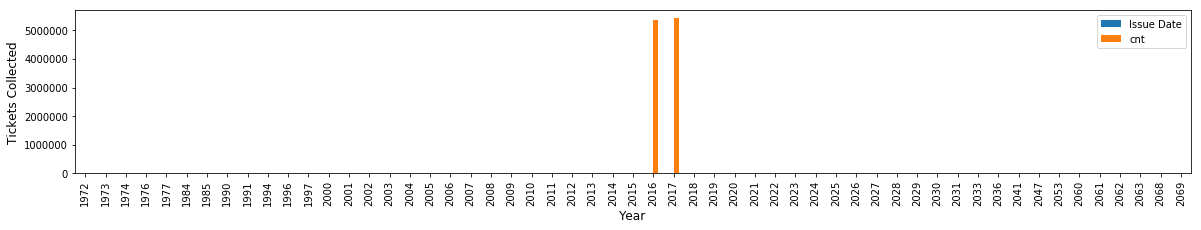

In [10]:
# Let's analyze the Issue Date column to see how many year's worth of data do we have
from pyspark.sql.functions import year
from pyspark.sql.functions import count

# Let's see using a plot of frequency by year on if there exists data outside of just 2017
year_freq = df \
            .withColumn('Issue Date', year(col('Issue Date'))) \
            .groupBy('Issue Date') \
            .agg(count('Issue Date').alias('cnt')) \
            .orderBy('Issue Date')

# Plotting the year wise frequency of the data in a bor plot to visualize the distribution 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

year_freq_pd = year_freq.toPandas()
year_freq_pd.index = year_freq_pd['Issue Date']

# plt.figure(figsize=(1,1))
year_freq_pd.plot.bar()
plt.xlabel('Year', fontsize=12)
plt.ylabel('Tickets Collected', fontsize=12)
plt.gcf().set_size_inches(20, 3)
plt.show()

In [11]:
# # We can see that the file holds data for a number of years, and not just 2017. We'll need to filter other years' data out
# # We see that there is data for many years other than 2017
# # Let's filter out the data so that it only holds data for 2017
# df2017 = df.select('*').filter(year('Issue Date') == 2017)
# df2017.show(2)

The above piece of code would be used to extract the data for just ther year 2017. However, **since we've been explicitly asked by the TA to consider the entire data for this analysis, the above code has been commented out and we'll proceed with the entire data for further analysis**

In [12]:
df2017 = df.select('*')

In [13]:
# Next, in our analysis moving forward, we would be analyzing the data in form of a sql table.
# Let's create a SQL table view from our df
df2017.createOrReplaceTempView("df2017_sql")

In [14]:
# Let's cache this table for quicker analysis
df2017.cache()

DataFrame[Summons Number: bigint, Plate ID: string, Registration State: string, Issue Date: timestamp, Violation Code: int, Vehicle Body Type: string, Vehicle Make: string, Violation Precinct: int, Issuer Precinct: int, Violation Time: string]

** Questions to Be Answered in the Analysis:**

**Examine the data** 
1. Find the total number of tickets for the year.

In [15]:
from pyspark.sql.functions import count

df2017 \
.select(col('Summons Number')) \
.distinct() \
.count()

10803028

2. Find out the number of unique states from where the cars that got parking tickets came. (Hint: Use the column 'Registration State'.)

There is a numeric entry '99' in the column, which should be corrected. Replace it with the state having the maximum entries. Provide the number of unique states again.

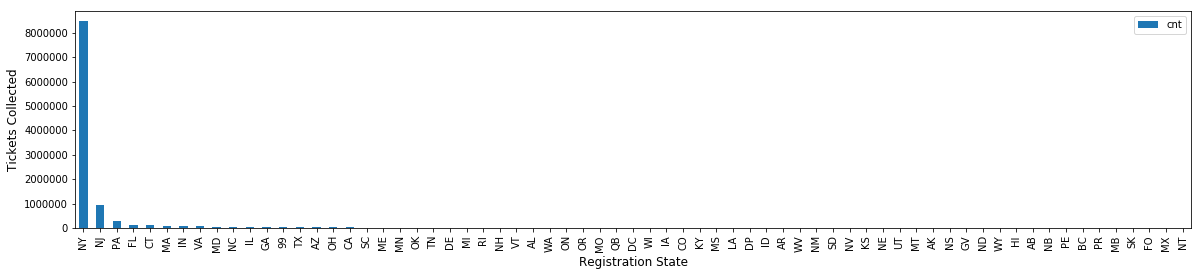

In [16]:
# First, let's check the different Registration states in the data
reg_state_freq = df2017 \
                 .groupBy('Registration State') \
                 .agg(count('Registration State').alias('cnt')) \
                 .orderBy('cnt', ascending = False)

# Plotting the Registration State wise tickets collected in a bor plot to visualize the distribution 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

reg_state_freq_pd = reg_state_freq.toPandas()
reg_state_freq_pd.index = reg_state_freq_pd['Registration State']

# plt.figure(figsize=(1,1))
reg_state_freq_pd.plot.bar()
plt.xlabel('Registration State', fontsize=12)
plt.ylabel('Tickets Collected', fontsize=12)
plt.gcf().set_size_inches(20, 4)
plt.show()

In [17]:
# We see that the State with most registrations is NY.
# Also, we observe that there is a state entry as '99'. 
# As requested, let's replace these entries with NY (state with most registrations)
from pyspark.sql.functions import regexp_replace

df2017 = df2017.withColumn('Registration State', regexp_replace(col('Registration State'),'99', 'NY'))

In [18]:
# Now getting to the question, the number of unique states from where the cars that got parking tickets came
df2017 \
.select('Registration State') \
.distinct() \
.agg(count('*')).show()

+--------+
|count(1)|
+--------+
|      66|
+--------+



In [19]:
# We see that there are 66 unique states from where the cars got parking tickets

**Aggregation tasks**
1. How often does each violation code occur? Display the frequency of the top five violation codes.

In [20]:
# First, let's perform an aggregation on Violation Code to identify the count of entries for each in the data
violation_code_freq = df2017 \
                      .groupBy('Violation Code') \
                      .agg(count('Violation Code').alias('Frequency')) \
                      .orderBy('Violation Code')

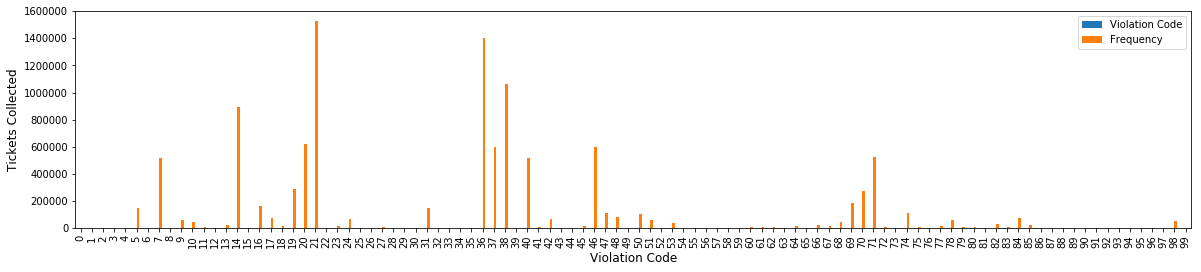

In [21]:
# Plotting the Violation Code Frequency in a bor plot to visualize the distribution 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

violation_code_freq_pd = violation_code_freq.toPandas()
violation_code_freq_pd.index = violation_code_freq_pd['Violation Code']

# plt.figure(figsize=(1,1))
violation_code_freq_pd.plot.bar()
plt.xlabel('Violation Code', fontsize=12)
plt.ylabel('Tickets Collected', fontsize=12)
plt.gcf().set_size_inches(20, 4)
plt.show()

In [22]:
# Displaying the frequency numbers for the top 5 violation codes
violation_code_freq.orderBy('Frequency', ascending = False).show(5)

+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            21|  1528588|
|            36|  1400614|
|            38|  1062304|
|            14|   893498|
|            20|   618593|
+--------------+---------+
only showing top 5 rows



2. How often does each 'vehicle body type' get a parking ticket? How about the 'vehicle make'? (Hint: Find the top 5 for both.)

In [23]:
# First, let's perform an aggregation on Violation Code to identify the count of entries for each in the data
vehicle_body_freq = df2017 \
                    .groupBy('Vehicle Body Type') \
                    .agg(count('Vehicle Body Type').alias('Frequency')) \
                    .orderBy('Frequency', ascending = False)

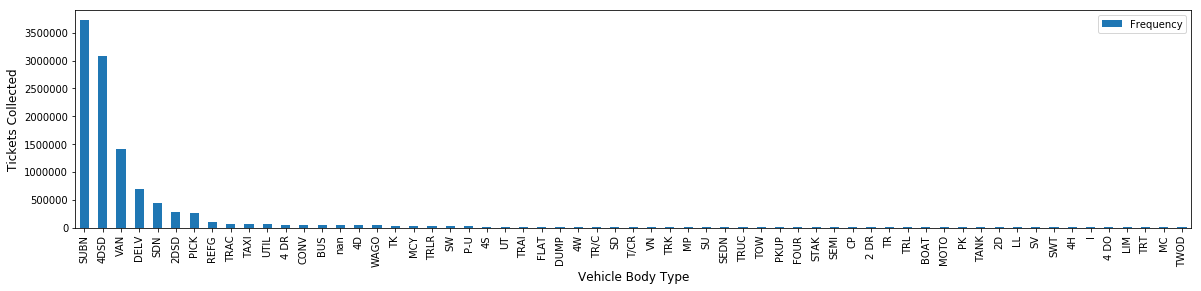

In [24]:
# Plotting the Vehicle Body Type Frequency in a bor plot to visualize the distribution (atleast more than 1000 tickets collected)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

vehicle_body_freq_pd = vehicle_body_freq.toPandas()
vehicle_body_freq_pd.index = vehicle_body_freq_pd['Vehicle Body Type']

# plt.figure(figsize=(1,1))
vehicle_body_freq_pd.loc[vehicle_body_freq_pd['Frequency']>1000, :].plot.bar()
plt.xlabel('Vehicle Body Type', fontsize=12)
plt.ylabel('Tickets Collected', fontsize=12)
plt.gcf().set_size_inches(20, 4)
plt.show()

In [25]:
# Displaying the top 5 'vehicle body type' frequencies
vehicle_body_freq.show(5)

+-----------------+---------+
|Vehicle Body Type|Frequency|
+-----------------+---------+
|             SUBN|  3719802|
|             4DSD|  3082020|
|              VAN|  1411970|
|             DELV|   687330|
|              SDN|   438191|
+-----------------+---------+
only showing top 5 rows



In [26]:
# Next, let's perform an aggregation on Vehicle Make to identify the count of entries for each in the data
vehicle_make_freq = df2017 \
                    .groupBy('Vehicle Make') \
                    .agg(count('Vehicle Make').alias('Frequency')) \
                    .orderBy('Frequency', ascending = False)

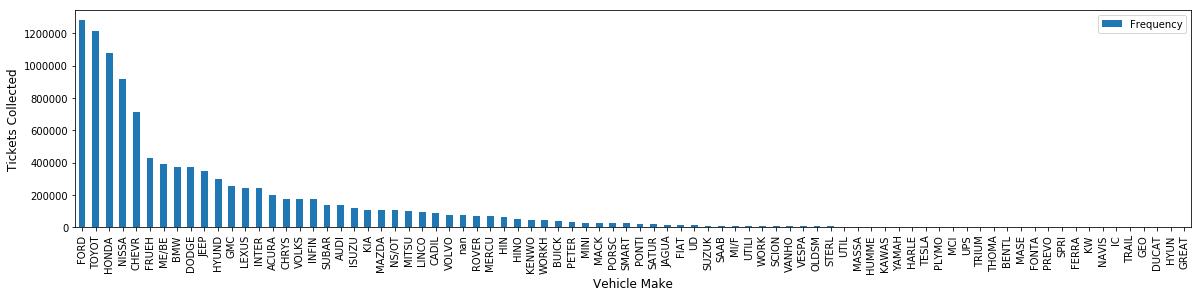

In [27]:
# Plotting the Vehicle Make Frequency in a bor plot to visualize the distribution (atleast more than 1000 tickets collected)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

vehicle_make_freq_pd = vehicle_make_freq.toPandas()
vehicle_make_freq_pd.index = vehicle_make_freq_pd['Vehicle Make']

# plt.figure(figsize=(1,1))
vehicle_make_freq_pd.loc[vehicle_make_freq_pd['Frequency']>1000, :].plot.bar()
plt.xlabel('Vehicle Make', fontsize=12)
plt.ylabel('Tickets Collected', fontsize=12)
plt.gcf().set_size_inches(20, 4)
plt.show()

In [28]:
# Displaying the top 5 'vehicle make' frequencies
vehicle_make_freq.show(5)

+------------+---------+
|Vehicle Make|Frequency|
+------------+---------+
|        FORD|  1280958|
|       TOYOT|  1211451|
|       HONDA|  1079238|
|       NISSA|   918590|
|       CHEVR|   714655|
+------------+---------+
only showing top 5 rows



3. A precinct is a police station that has a certain zone of the city under its command. Find the (5 highest) frequencies of tickets for each of the following:
    - 'Violation Precinct' (This is the precinct of the zone where the violation occurred). Using this, can you draw any insights for parking violations in any specific areas of the city?
    - 'Issuer Precinct' (This is the precinct that issued the ticket.)

Here, you would have noticed that the dataframe has the 'Violating Precinct' or 'Issuing Precinct' as '0'. These are erroneous entries. Hence, you need to provide the records for five correct precincts. (Hint: Print the top six entries after sorting.)

In [29]:
# Displaying the top 5 'Violation Precinct' frequencies
# We see that there is an erroneos value of 0 in the columns, hence we'll be printing the top 6
violation_precinct_freq = df2017 \
                          .groupBy('Violation Precinct') \
                          .agg(count('Violation Precinct').alias('Frequency')) \
                          .orderBy('Frequency', ascending = False)

violation_precinct_freq.show(6)

+------------------+---------+
|Violation Precinct|Frequency|
+------------------+---------+
|                 0|  2072400|
|                19|   535671|
|                14|   352450|
|                 1|   331810|
|                18|   306920|
|               114|   296514|
+------------------+---------+
only showing top 6 rows



In [30]:
issuer_precinct_freq = df2017 \
                       .groupBy('Issuer Precinct') \
                       .agg(count('Issuer Precinct').alias('Frequency')) \
                       .orderBy('Frequency', ascending = False)

issuer_precinct_freq.show(6)

+---------------+---------+
|Issuer Precinct|Frequency|
+---------------+---------+
|              0|  2388479|
|             19|   521513|
|             14|   344977|
|              1|   321170|
|             18|   296553|
|            114|   289950|
+---------------+---------+
only showing top 6 rows



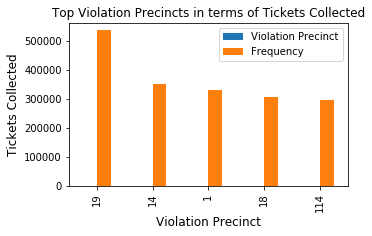

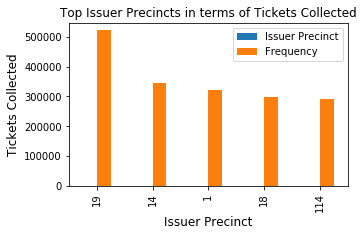

In [31]:
# Let's visualize the issuer precincts with most number of tickets collected (excluding 0)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

violation_precinct_freq_pd = violation_precinct_freq.toPandas()
violation_precinct_freq_pd.index = violation_precinct_freq_pd['Violation Precinct']

issuer_precinct_freq_pd = issuer_precinct_freq.toPandas()
issuer_precinct_freq_pd.index = issuer_precinct_freq_pd['Issuer Precinct']

# plt.figure(figsize=(1,1))
violation_precinct_freq_pd.loc[violation_precinct_freq_pd['Violation Precinct']!=0,:].head(5).plot.bar()
plt.xlabel('Violation Precinct', fontsize=12)
plt.ylabel('Tickets Collected', fontsize=12)
plt.title('Top Violation Precincts in terms of Tickets Collected')
plt.gcf().set_size_inches(5, 3)

issuer_precinct_freq_pd.loc[issuer_precinct_freq_pd['Issuer Precinct']!=0,:].head(5).plot.bar()
plt.xlabel('Issuer Precinct', fontsize=12)
plt.ylabel('Tickets Collected', fontsize=12)
plt.title('Top Issuer Precincts in terms of Tickets Collected')
plt.gcf().set_size_inches(5, 3)


In [32]:
# We can see that the trend is the same for the top Issuer and Violation Precincts.
# This tells us that, for the most cases, the issues are being registered in the same place where the violations occur

4. Find the violation code frequencies for three precincts that have issued the most number of tickets. Do these precinct zones have an exceptionally high frequency of certain violation codes? Are these codes common across precincts? 

    (Hint: In the SQL view, use the 'where' attribute to filter among three precincts.)

In [33]:
# Looking at the hint, we're expected to use SQL based table/view to perform the analysis
# Let's recreate a SQL table view from our df
df2017.createOrReplaceTempView("df2017_sql")

# The top 3 Issuer Precincts in terms of tickets issued are 19,14,1
ip19_violations = spark.sql('select `Issuer Precinct`, `Violation Code`, count(*) as Frequency \
                             from df2017_sql \
                             where `Issuer Precinct` = 19 \
                             group by 1, 2 \
                             order by 1, 3 desc')

ip14_violations = spark.sql('select `Issuer Precinct`, `Violation Code`, count(*) as Frequency \
                             from df2017_sql \
                             where `Issuer Precinct` = 14 \
                             group by 1, 2 \
                             order by 1, 3 desc')

ip1_violations = spark.sql('select `Issuer Precinct`, `Violation Code`, count(*) as Frequency \
                            from df2017_sql \
                            where `Issuer Precinct` = 1 \
                            group by 1, 2 \
                            order by 1, 3 desc')

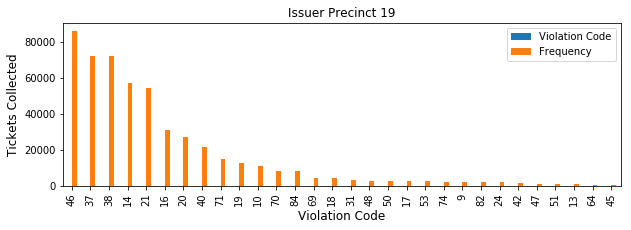

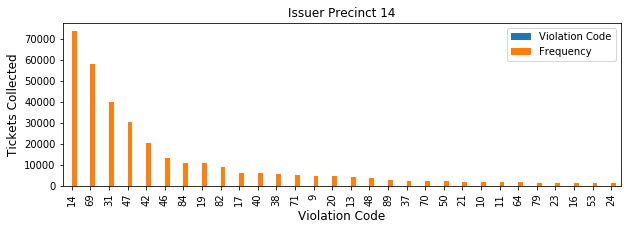

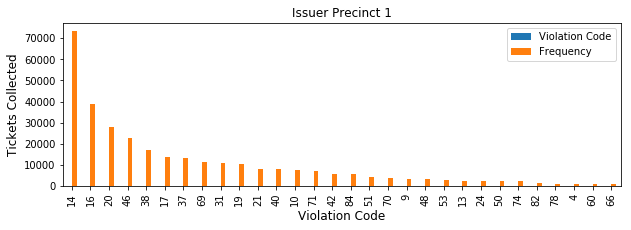

In [34]:
# Plotting the 3 Issuer precincts' data to understand whether they have a high frequency of certain violation codes
# Let's plot the top 30 Violation Codes within each precinct
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

ip19_violations_pd = ip19_violations.select('Violation Code', 'Frequency').toPandas()
ip19_violations_pd.index = ip19_violations_pd['Violation Code']

ip14_violations_pd = ip14_violations.select('Violation Code', 'Frequency').toPandas()
ip14_violations_pd.index = ip14_violations_pd['Violation Code']

ip1_violations_pd = ip1_violations.select('Violation Code', 'Frequency').toPandas()
ip1_violations_pd.index = ip1_violations_pd['Violation Code']

# plt.figure(figsize=(1,1))
ip19_violations_pd.head(30).plot.bar()
plt.xlabel('Violation Code', fontsize=12)
plt.ylabel('Tickets Collected', fontsize=12)
plt.title('Issuer Precinct 19')
plt.gcf().set_size_inches(10, 3)

ip14_violations_pd.head(30).plot.bar()
plt.xlabel('Violation Code', fontsize=12)
plt.ylabel('Tickets Collected', fontsize=12)
plt.title('Issuer Precinct 14')
plt.gcf().set_size_inches(10, 3)

ip1_violations_pd.head(30).plot.bar()
plt.xlabel('Violation Code', fontsize=12)
plt.ylabel('Tickets Collected', fontsize=12)
plt.title('Issuer Precinct 1')
plt.gcf().set_size_inches(10, 3)

plt.show()


In [35]:
# We observe that the different precincts have different distributions of violation codes in terms of tickets collected.
# Precinct 19's top 3 violation codes were 46, 37, 38
# Precinct 14's top 3 violation codes were 14, 69, 31
# Precinct 1's top 3 violation codes were 14, 16, 20
# The violations therefore vary across different precincts
# However, the violation code 14 is one that appeared among the top of all the 3 precincts analyzed

5. Find out the properties of parking violations across different times of the day:
    - Find a way to deal with missing values, if any.
    (Hint: Check for the null values using 'isNull' under the SQL. Also, to remove the null values, check the 'dropna' command in the API documentation.)

    - The Violation Time field is specified in a strange format. Find a way to make this a time attribute that you can use to divide into groups.

    - Divide 24 hours into six equal discrete bins of time. Choose the intervals as you see fit. For each of these groups, find the three most commonly occurring violations.
    (Hint: Use the CASE-WHEN in SQL view to segregate into bins. To find the most commonly occurring violations, you can use an approach similar to the one mentioned in the hint for question 4.)

    - Now, try another direction. For the three most commonly occurring violation codes, find the most common time of the day (in terms of the bins from the previous part).

In [36]:
# Firstly, let's check for any missing values in the data
# We will do this individually for each of the columns in the dataset using the sql is null command
spark.sql('select sum(case when `Summons Number` is null then 1 else 0 end) as summon_number_nulls, \
           sum(case when `Plate ID` is null then 1 else 0 end) as plate_id_nulls, \
           sum(case when `Registration State` is null then 1 else 0 end) as reg_state_nulls, \
           sum(case when `Issue Date` is null then 1 else 0 end) as issue_date_nulls, \
           sum(case when `Violation Code` is null then 1 else 0 end) as violation_code_nulls, \
           sum(case when `Vehicle Body Type` is null then 1 else 0 end) as veh_body_type_nulls, \
           sum(case when `Vehicle Make` is null then 1 else 0 end) as veh_make_nulls, \
           sum(case when `Violation Precinct` is null then 1 else 0 end) as violation_precinct_nulls, \
           sum(case when `Issuer Precinct` is null then 1 else 0 end) as issuer_precinct_nulls, \
           sum(case when `Violation Time` is null then 1 else 0 end) as violation_time_nulls \
           from df2017_sql').show()


+-------------------+--------------+---------------+----------------+--------------------+-------------------+--------------+------------------------+---------------------+--------------------+
|summon_number_nulls|plate_id_nulls|reg_state_nulls|issue_date_nulls|violation_code_nulls|veh_body_type_nulls|veh_make_nulls|violation_precinct_nulls|issuer_precinct_nulls|violation_time_nulls|
+-------------------+--------------+---------------+----------------+--------------------+-------------------+--------------+------------------------+---------------------+--------------------+
|                  0|             0|              0|               0|                   0|                  0|             0|                       0|                    0|                   0|
+-------------------+--------------+---------------+----------------+--------------------+-------------------+--------------+------------------------+---------------------+--------------------+



In [37]:
# We can see that there are no null values in the dataset
# Next, we've been asked to convert the Violation Time into a lot more understandable format

# The Violation Time column is in the format HHmmA where the last character stands for AM/PM.
# Let's convert this into 24 hour format timestamp (we'll take the date value from Issue Date and the time component from the violation time)
df2017_time = spark.sql("select *, \
        case when `Violation Time` like '%A' then \
            cast(UNIX_TIMESTAMP(concat(to_date(`Issue Date`), cast(substring(time_new, 0, 2) as int),':',substring(time_new, 3, 2),':00'), 'yyyy-mm-ddHH:mm:ss') as timestamp) \
        else cast(UNIX_TIMESTAMP(concat(to_date(`Issue Date`), cast(substring(time_new, 0, 2) as int)+12 ,':',substring(time_new, 3, 2),':00'), 'yyyy-mm-ddHH:mm:ss') as timestamp) end as `Violation Time New`  \
        from (select *, \
              concat(replace(substring(`Violation Time`, 0, 2), '12', '00'), substring(`Violation Time`, 3, 3)) as time_new \
              from df2017_sql)")

# Let's create a SQL table/view for the above created table
df2017_time.createOrReplaceTempView("df2017_time")

# Next, we'll create a new column for the Violation Hour where we'll extract the hour from the 24-hour format violation time
# This new hour column will then be used for bucketing later
df2017_time = spark.sql("select *, hour(`Violation Time New`) as `Violation Hour` \
                         from df2017_time")

df2017_time.createOrReplaceTempView("df2017_time")

In [38]:
# Divide 24 hours into six equal discrete bins of time - this means each bucket should be within a 4-hour interval
# Let's use the following bins (0:4 - MidNight, 4:8 - Early Morning, 8:12 - Late Morning, 12:16 - Afternoon, 16:20 - Evening, 20:24 - Night)
df2017_time = spark.sql("select *, \
                         case when `Violation Hour`<4 then 'Mid-Night' \
                              when `Violation Hour`>=4 and `Violation Hour`<8 then 'Early Morning' \
                              when `Violation Hour`>=8 and `Violation Hour`<12 then 'Late Morning' \
                              when `Violation Hour`>=12 and `Violation Hour`<16 then 'Afternoon' \
                              when `Violation Hour`>=16 and `Violation Hour`<20 then 'Evening' \
                              when `Violation Hour`>=20 then 'Night' \
                              else null end as day_part \
                         from df2017_time")

df2017_time.createOrReplaceTempView("df2017_time")

In [39]:
# Looking at a sample for the Violation Time
df2017_time \
.select('Violation Time') \
.orderBy('Violation Time').show(5)

+--------------+
|Violation Time|
+--------------+
|         .240P|
|         .359A|
|         .933A|
|         0+45A|
|         0.22A|
+--------------+
only showing top 5 rows



In [40]:
# We can see that there are nan values in the Violation Time column, which we couldn't find using the isnull command.
# Also, there are some data points in the column that are erroneous. We will be excluding these values in the following analysis

In [41]:
# For each of these groups, find the three most commonly occurring violations.
# First, let's create a temporary table holding the frequency values for each of the violation codes within a daypart
daypart_temp = spark.sql('select day_part, `Violation Code`, count(*) as Frequency \
                          from df2017_time \
                          where day_part is not null \
                          group by 1,2')

daypart_temp.createOrReplaceTempView("daypart_temp")

# Next Let, assign a rank to ach value in descending order of Frequency partitioned by the day_part
daypart_temp2 = spark.sql("select day_part, `Violation Code`, Frequency, \
                                  rank() over (partition by day_part order by Frequency desc) as rnk \
                           from daypart_temp")

daypart_temp2.createOrReplaceTempView("daypart_temp2")

# Finally, let's find the top 3 violations in each day_part
day_violation_freq = spark.sql("select day_part, `Violation Code`, Frequency \
                                from daypart_temp2 \
                                where rnk<=3")
day_violation_freq.show()

+-------------+--------------+---------+
|     day_part|Violation Code|Frequency|
+-------------+--------------+---------+
|      Evening|            38|   203232|
|      Evening|            37|   145784|
|      Evening|            14|   144748|
|Early Morning|            14|   141275|
|Early Morning|            21|   119466|
|Early Morning|            40|   112186|
|    Afternoon|            36|   588395|
|    Afternoon|            38|   462758|
|    Afternoon|            37|   337075|
| Late Morning|            21|  1182676|
| Late Morning|            36|   751422|
| Late Morning|            38|   346518|
|        Night|             7|    65593|
|        Night|            38|    47029|
|        Night|            14|    44778|
|    Mid-Night|            21|    77461|
|    Mid-Night|            40|    50947|
|    Mid-Night|            78|    32243|
+-------------+--------------+---------+



In [42]:
# The 3 most occuring Violation Codes for each of the day buckets are as shown above
# Early Morning: 14, 21, 40
# Late Morning: 21, 36, 38
# Afternoon: 36, 38, 37
# Evening: 38, 37, 14
# Night: 7, 38, 14
# Mid-Night: 21, 40, 78

In [43]:
# Now, For the three most commonly occurring violation codes, find the most common time of the day (in terms of the bins from the previous part).
# First, let's find the 3 most commonly occuring violation codes
df2017_time.groupBy('Violation Code') \
           .agg(count('*').alias('Frequency')) \
           .orderBy('Frequency', ascending = False).show(3)

+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            21|  1528588|
|            36|  1400614|
|            38|  1062304|
+--------------+---------+
only showing top 3 rows



In [44]:
# Next, let's find the most common times of day where tickets are issued for each of the top 3 violation codes
df2017_time.select('Violation Code', 'day_part') \
           .where((col('Violation Code').isin(21,36,38)) & (col('day_part').isNotNull())) \
           .groupBy('Violation Code', 'day_part') \
           .agg(count('day_part').alias('Frequency')) \
           .orderBy('Violation Code', 'Frequency', ascending = False).show()

+--------------+-------------+---------+
|Violation Code|     day_part|Frequency|
+--------------+-------------+---------+
|            38|    Afternoon|   462758|
|            38| Late Morning|   346518|
|            38|      Evening|   203232|
|            38|        Night|    47029|
|            38|Early Morning|     2300|
|            38|    Mid-Night|      464|
|            36| Late Morning|   751422|
|            36|    Afternoon|   588395|
|            36|Early Morning|    33939|
|            36|      Evening|    26858|
|            21| Late Morning|  1182676|
|            21|    Afternoon|   148012|
|            21|Early Morning|   119466|
|            21|    Mid-Night|    77461|
|            21|      Evening|      551|
|            21|        Night|      365|
+--------------+-------------+---------+



6. Let’s try and find some seasonality in this data:

    - First, divide the year into a certain number of seasons, and find the frequencies of tickets for each season. (Hint: Use Issue Date to segregate into seasons.)

    - Then, find the three most common violations for each of these seasons.
    (Hint: You can use an approach similar to the one mentioned in the hint for question 4.)

In [45]:
# Considering we're looking at data for the US, let's identify the different seasons that exist during the year in the year
# Spring (March - May), Summer (June - August), Autumn (September - November), Winter (December - February)
# Let's first create a column in the df2017 dataset which will hold the month of issue date
from pyspark.sql.functions import month
df2017_time = df2017_time.withColumn('Issue Month', month('Issue Date'))
df2017_time.createOrReplaceTempView("df2017_time")

# Let's add the seasons data to the dataframe corresponding to the months of the year
df2017_time = spark.sql("select *, \
                                case when `Issue Month`>=3 and `Issue Month`<=5 then 'Spring' \
                                     when `Issue Month`>=6 and `Issue Month`<=8 then 'Summer' \
                                     when `Issue Month`>=9 and `Issue Month`<=11 then 'Autumn' \
                                     else 'Winter' end as Season \
                         from df2017_time")

df2017_time.createOrReplaceTempView("df2017_time")

In [46]:
# Let's find the frequency of tickets in each season
df2017_time.groupBy('Season') \
           .agg(count('*').alias('Frequency')) \
           .orderBy('Frequency', ascending = False).show()

+------+---------+
|Season|Frequency|
+------+---------+
|Spring|  2880687|
|Autumn|  2830802|
|Summer|  2606208|
|Winter|  2485331|
+------+---------+



In [47]:
# For each of the seasons, find the three most commonly occurring violations.
# First, let's create a temporary table holding the frequency values for each of the violation codes within a season
season_temp = spark.sql('select Season, `Violation Code`, count(*) as Frequency \
                         from df2017_time \
                         group by 1,2')

season_temp.createOrReplaceTempView("season_temp")

# Next Let, assign a rank to ach value in descending order of Frequency partitioned by the day_part
season_temp2 = spark.sql("select Season, `Violation Code`, Frequency, \
                                 rank() over (partition by Season order by Frequency desc) as rnk \
                          from season_temp")

season_temp2.createOrReplaceTempView("season_temp2")

# Finally, let's find the top 3 violations in each day_part
spark.sql("select Season, `Violation Code`, Frequency \
           from season_temp2 \
           where rnk<=3").show()

+------+--------------+---------+
|Season|Violation Code|Frequency|
+------+--------------+---------+
|Spring|            21|   402807|
|Spring|            36|   344834|
|Spring|            38|   271192|
|Summer|            21|   405961|
|Summer|            38|   247561|
|Summer|            36|   240396|
|Autumn|            36|   456046|
|Autumn|            21|   357479|
|Autumn|            38|   283828|
|Winter|            21|   362341|
|Winter|            36|   359338|
|Winter|            38|   259723|
+------+--------------+---------+



In [48]:
# The 3 most occuring Violation Codes for each of the seasons are as shown above
# Spring: 21, 36, 38
# Summer: 21, 38, 36
# Autumn: 36, 21, 38
# Winter: 21, 36, 38

In [49]:
# We can see that across all the seasons, the top 3 violation codes are more or less very similar (interchangeably)

7. The fines collected from all the instances of parking violation constitute a source of revenue for the NYC Police Department. Let’s take an example of estimating this for the three most commonly occurring codes:
    - Find the total occurrences of the three most common violation codes.
    - Then, visit the website: http://www1.nyc.gov/site/finance/vehicles/services-violation-codes.page
    - It lists the fines associated with different violation codes. They’re divided into two categories: one for the highest-density locations in the city and the other for the rest of the city. For the sake of simplicity, take the average of the two.
    - Using this information, find the total amount collected for the three violation codes with the maximum tickets. State the code that has the highest total collection.
    - What can you intuitively infer from these findings?

In [50]:
# First let's find the total occurence of the 3 most common violation codes
violation_code_freq2 = df2017_time.groupBy('Violation Code') \
                                  .agg(count('*').alias('Frequency')) \
                                  .orderBy('Frequency', ascending = False)

violation_code_freq2.createOrReplaceTempView("violation_code_freq2")
violation_code_freq2.show(3)

+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            21|  1528588|
|            36|  1400614|
|            38|  1062304|
+--------------+---------+
only showing top 3 rows



In [51]:
# From the above analysis, we can infer that the top violation codes were 21, 36 and 38 in terms of tickets collected
# Using the data on the site listed, the average price for the violation codes is as follows:
# 21 --> (65+45)/2 = 55, 36 --> (50+50)/2 = 50, 38 --> (65+35)/2 = 50

In [52]:
# Let's use this to find the total amount collected for the 3 violation codes with the maximum tickets:
spark.sql("select `Violation Code`, Frequency as `Tickets Collected`, \
                   case when `Violation Code` = 21 then Frequency*55 \
                        when `Violation Code` = 36 then Frequency*50 \
                        when `Violation Code` = 38 then Frequency*50 \
                        else null end as `Total Amount` \
           from violation_code_freq2 \
           where `Violation Code` in (21, 36, 38)").show()

+--------------+-----------------+------------+
|Violation Code|Tickets Collected|Total Amount|
+--------------+-----------------+------------+
|            21|          1528588|    84072340|
|            36|          1400614|    70030700|
|            38|          1062304|    53115200|
+--------------+-----------------+------------+



In [53]:
# From the above analysis, we can infer that the majority of the tickets were collected for the Violation Code 21
# Offense Definition- Street Cleaning: No parking where parking is not allowed by sign, street marking or traffic control device
# In terms of the amount collected, the highest was collected for the Violation Code 21 too!

In [54]:
# Now that we're done with the analysis, let's stop the Spark cluster
spark.stop()